STAT 479: Deep Learning (Spring 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/  
GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19

---

# Homework 4: Implementing a Convolutional Neural Network (40 pts)

In this 4th homework, your task is to implement a convolutional neural network for classifying images in the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 

### Dataset Overview

- The CIFAR-10 dataset contains 60,000 color images with pixel dimensions 32x32. 
- There are 50,000 training images and 10,000 test images
- Shown below is a snapshot showing a random selection for the 10 different object classes (from https://www.cs.toronto.edu/~kriz/cifar.html):

![](cifar-snapshot.png)

The CIFAR-10 dataset is already made accessible via the PyTorch API as it is a common dataset for benchmarking image classifiers. Hence, you do not have to download the dataset manually -- it will be downloaded automatically when you call

```python
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)
```

in the provided code cells below for the first time. Thus, keep in mind that calling this function for the first time may be a bit slow depending on your internet connection. On a conventional internet connection, it should be downloaded in a matter of seconds, though.

Note that we are **not** using a separate validation dataset in this homework for tuning this network. This is intentional for the purposes of simplicity. However, in a real-world application, you are highly advised to use a validation dataset to tune the hyper parameters of the network as discussed in class.

### Your Tasks

Your main task is to implement a simple convolutional neural network that is loosely inspired by the AlexNet architecture that one the ImageNet competition in 2012: 

- Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). [Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) (pp. 1097-1105).

Then, you will make several simple modifications to this network architecture to improve its performance.

Note that in this homework, as explained above, you will NOT be working with ImageNet but CIFAR-10, which is a much smaller dataset, in order for you to be able to train the network in a timely manner.

In particular, you will be asked to first implement a basic convolutional neural network based on AlexNet and then make several improvements to optimize the performance and reduce overfitting. These "improvements" include Dropout, BatchNorm, and image augmentation, which will serve as a good exercise for familiarizing yourself with "Deep Learning Tricks" as well as convolutional neural networks.

Note that the homework is relatively easy and straightforward, but the training of the network in each of the 5 sections will take ~5 min to train on a GPU. On a CPU, it will probably be much longer. Because training on the CPU will take much longer, and because you probably don't want your computer to overheat, I **highly recommend running this homework on a cloud server**, for example, Google Colab (which allows you to use a GPU for free). Since you don't have to download the dataset manually, it should be relatively straightforward to do this homework on Google Colab and then download the solution for submission via Canvas. Please let me know if you have any questions about that. For a Cloud computing refresher, please see: https://github.com/rasbt/stat479-deep-learning-ss19/tree/master/L07_cloud-computing.

**The due date for this homework is Friday, 11 April 11:59 pm.** Please start as soon as possible, because while this homework is conceptually straightforward, you have to factor in the computation time (~30 min runtime for the complete notebook if you run this notebook with correct solutions).

In [5]:
!pip install watermark

## Imports

In [ ]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [6]:
%load_ext watermark
%watermark -a 'ZhuoyanXU' -ud -iv 

PIL         4.1.1
torchvision 0.2.2
pandas      0.22.0
matplotlib  3.0.3
torch       1.0.1.post2
IPython     5.5.0
numpy       1.14.6
ZhuoyanXU 
last updated: 2019-04-10


<br>
<br>

## Model Settings

In [ ]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################


#-------------------------
### SETTINGS
#-------------------------

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

<br>
<br>

## Dataset

In [8]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

#-------------------------
### CIFAR-10 Dataset
#-------------------------


# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

0it [00:00, ?it/s]

170500096it [00:08, 19663045.51it/s]                              


Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


In [ ]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


<br>
<br>

In [ ]:
## 1) Implement a Convolutional Neural Network

In this part, you will be implementing the AlexNet-variant that you will be using and modifying throughout this homework. On purpose, this will be a bit more "hands-off" than usual, so that you get a chance to practice implementing neural networks from scratch based on sketches and short descriptions (which is a useful real-world skill as it is quite common to reimplement architectures from literature in order to verify results and compare those architectures to your own methods).

The architecture is as follows:

![](architecture-1.png)

Note that I made this network based on AlexNet, as mentioned in the introduction, but there are some differences. Overall though, there are 7 hidden layers in total: 5 convolutional layers and 2 fully-connected layers. There is one output layers mapping the last layer's activations to the classes. For this network, 

- all hidden layers are connected via ReLU activation functions
- the output layer uses a softmax activation function
- make sure you return the logits and the softmax output; the logits are used for computing the cross-entropy loss (instead of passing the softmax outputs) for numerical stability reasons as discussed in earlier lectures.

In [ ]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet1, self).__init__()

        self.conv1 = nn.Conv2d(3, 64,    kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size = 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool5 = nn.MaxPool2d(2)
        
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        
        self.linear1 = nn.Linear(256, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, num_classes)  
        

    def forward(self, x):
        
        # ... IMPLEMENT FORWARD PASS ...
        out_1 = self.conv1(x)
        out_1 = torch.relu(out_1)
        out_1 = self.pool1(out_1)
        
        out_2 = self.conv2(out_1)
        out_2 = torch.relu(out_2)
        out_2 = self.pool2(out_2)
        
        out_3 = self.conv3(out_2)
        out_3 = torch.relu(out_3)
        out_3 = self.pool3(out_3)
        
        out_4 = self.conv4(out_3)
        out_4 = torch.relu(out_4)
        out_4 = self.pool4(out_4)
        
        out_5 = self.conv5(out_4)
        out_5 = torch.relu(out_5)
        out_5 = self.pool5(out_5)
        #print(out_5.size())
        out_5 = out_5.view(-1,256)
        #print(out_5.size())
        
        out_6 = self.linear1(out_5)
        out_6 = torch.relu(out_6)
        
        out_7 = self.linear2(out_6)
        out_7 = torch.relu(out_7)
        
        out_8 = self.linear3(out_7)
        
        
        logits = out_8
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)
model1.to(DEVICE)

optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)  

Epoch: 001/020 | Batch 0000/0196 | Cost: 2.3027
Epoch: 001/020 | Batch 0150/0196 | Cost: 1.6545
Epoch: 001/020 | Train: 43.558%
Time elapsed: 1.39 min
Epoch: 002/020 | Batch 0000/0196 | Cost: 1.5554
Epoch: 002/020 | Batch 0150/0196 | Cost: 1.1869
Epoch: 002/020 | Train: 60.948%
Time elapsed: 2.79 min
Epoch: 003/020 | Batch 0000/0196 | Cost: 0.9969
Epoch: 003/020 | Batch 0150/0196 | Cost: 0.9897
Epoch: 003/020 | Train: 67.840%
Time elapsed: 4.18 min
Epoch: 004/020 | Batch 0000/0196 | Cost: 0.9396
Epoch: 004/020 | Batch 0150/0196 | Cost: 0.7135
Epoch: 004/020 | Train: 74.956%
Time elapsed: 5.57 min
Epoch: 005/020 | Batch 0000/0196 | Cost: 0.8245
Epoch: 005/020 | Batch 0150/0196 | Cost: 0.6786
Epoch: 005/020 | Train: 78.286%
Time elapsed: 6.96 min
Epoch: 006/020 | Batch 0000/0196 | Cost: 0.5638
Epoch: 006/020 | Batch 0150/0196 | Cost: 0.6567
Epoch: 006/020 | Train: 86.012%
Time elapsed: 8.35 min
Epoch: 007/020 | Batch 0000/0196 | Cost: 0.4650
Epoch: 007/020 | Batch 0150/0196 | Cost: 0.430

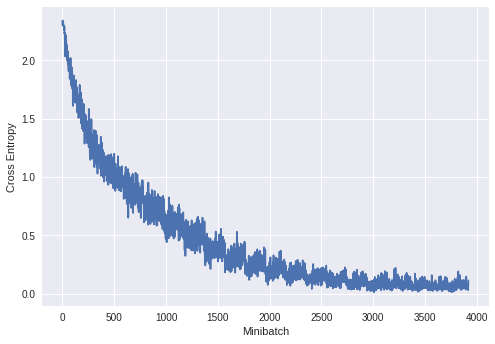

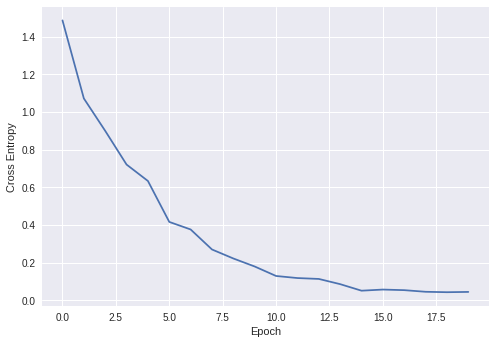

In [8]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    

minibatch_cost, epoch_cost = train(model1, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# del model1  # to save memory if you don't use it anymore

<br>
<br>

## 2) Adding Dropout

In this second part, your task is now to add dropout layers to reduce overfitting. You can copy&paste your architecture from above and make the appropriate modifications. In particular,

- place a Dropout2d (this is also referred to as "spatial dropout"; will be explained in the lecture) before each maxpooling layer with dropout probability p=0.2,
- place a regular dropout after each fully connected layer with probability p=0.5, except for the last (output) layer.

The architecture is as follows (changes, compared to the previous section, are highlighted in red):

![](architecture-2.png)

Epoch: 001/020 | Batch 0000/0196 | Cost: 2.3042
Epoch: 001/020 | Batch 0150/0196 | Cost: 1.7490
Epoch: 001/020 | Train: 40.736%
Time elapsed: 1.41 min
Epoch: 002/020 | Batch 0000/0196 | Cost: 1.5913
Epoch: 002/020 | Batch 0150/0196 | Cost: 1.3698
Epoch: 002/020 | Train: 54.092%
Time elapsed: 2.82 min
Epoch: 003/020 | Batch 0000/0196 | Cost: 1.3132
Epoch: 003/020 | Batch 0150/0196 | Cost: 1.2742
Epoch: 003/020 | Train: 61.926%
Time elapsed: 4.23 min
Epoch: 004/020 | Batch 0000/0196 | Cost: 1.1409
Epoch: 004/020 | Batch 0150/0196 | Cost: 1.0609
Epoch: 004/020 | Train: 65.322%
Time elapsed: 5.64 min
Epoch: 005/020 | Batch 0000/0196 | Cost: 1.1907
Epoch: 005/020 | Batch 0150/0196 | Cost: 1.1797
Epoch: 005/020 | Train: 69.916%
Time elapsed: 7.06 min
Epoch: 006/020 | Batch 0000/0196 | Cost: 0.8822
Epoch: 006/020 | Batch 0150/0196 | Cost: 0.9950
Epoch: 006/020 | Train: 72.652%
Time elapsed: 8.47 min
Epoch: 007/020 | Batch 0000/0196 | Cost: 1.0256
Epoch: 007/020 | Batch 0150/0196 | Cost: 0.830

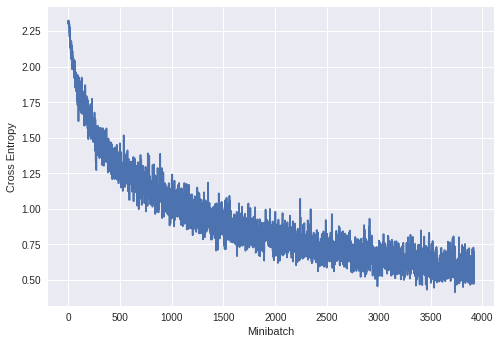

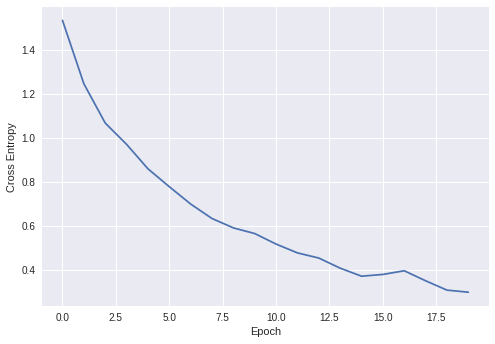

In [9]:
##########################
### MODEL
##########################

class ConvNet2(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64,    kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size = 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.2)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout2d(0.2)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout5 = nn.Dropout2d(0.2)
        
        
        self.linear1 = nn.Linear(256, 4096)
        self.lin_drop_1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(4096, 4096)
        self.lin_drop_2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(4096, num_classes) 
        #### YOUR CODE
        

    def forward(self, x):

         # ... IMPLEMENT FORWARD PASS ...
        out_1 = self.conv1(x)
        out_1 = self.dropout2(out_1)
        out_1 = torch.relu(out_1)
        out_1 = self.pool1(out_1)
        
        out_2 = self.conv2(out_1)
        out_2 = self.dropout2(out_2)
        out_2 = torch.relu(out_2)
        out_2 = self.pool2(out_2)
        
        out_3 = self.conv3(out_2)
        out_3 = self.dropout3(out_3)
        out_3 = torch.relu(out_3)
        out_3 = self.pool3(out_3)
        
        out_4 = self.conv4(out_3)
        out_4 = self.dropout4(out_4)
        out_4 = torch.relu(out_4)
        out_4 = self.pool4(out_4)
        
        out_5 = self.conv5(out_4)
        out_5 = self.dropout5(out_5)
        out_5 = self.pool5(out_5)
        out_5 = torch.relu(out_5)
        #print(out_5.size())
        out_5 = out_5.view(-1,256)
        #print(out_5.size())
        
        out_6 = self.linear1(out_5)
        out_6 = torch.relu(out_6)
        out_6 = self.lin_drop_1(out_6)
        
        out_7 = self.linear2(out_6)
        out_7 = torch.relu(out_7)
        out_7 = self.lin_drop_2(out_7)
        
        out_8 = self.linear3(out_7)
        
        
        logits = out_8
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model2 = ConvNet2(NUM_CLASSES)
model2.to(DEVICE)

optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model2, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# del model2  # to save memory if you don't use it anymore

<br>
<br>

## 3) Add BatchNorm

In this 3rd part, you are now going to add BatchNorm layers to further improve the performance of the network. This use BatchNorm2D for the convolutional layers and BatchNorm1D for the fully connected layers.


The architecture is as follows (changes, compared to the previous section, are highlighted in red):

![](architecture-3.png)

Epoch: 001/020 | Batch 0000/0196 | Cost: 2.3702
Epoch: 001/020 | Batch 0150/0196 | Cost: 1.4638
Epoch: 001/020 | Train: 52.678%
Time elapsed: 1.53 min
Epoch: 002/020 | Batch 0000/0196 | Cost: 1.2746
Epoch: 002/020 | Batch 0150/0196 | Cost: 1.0868
Epoch: 002/020 | Train: 65.006%
Time elapsed: 3.05 min
Epoch: 003/020 | Batch 0000/0196 | Cost: 0.9686
Epoch: 003/020 | Batch 0150/0196 | Cost: 0.9730
Epoch: 003/020 | Train: 67.190%
Time elapsed: 4.57 min
Epoch: 004/020 | Batch 0000/0196 | Cost: 0.9455
Epoch: 004/020 | Batch 0150/0196 | Cost: 0.7843
Epoch: 004/020 | Train: 74.966%
Time elapsed: 6.09 min
Epoch: 005/020 | Batch 0000/0196 | Cost: 0.6951
Epoch: 005/020 | Batch 0150/0196 | Cost: 0.7177
Epoch: 005/020 | Train: 71.400%
Time elapsed: 7.62 min
Epoch: 006/020 | Batch 0000/0196 | Cost: 0.7291
Epoch: 006/020 | Batch 0150/0196 | Cost: 0.6289
Epoch: 006/020 | Train: 73.946%
Time elapsed: 9.14 min
Epoch: 007/020 | Batch 0000/0196 | Cost: 0.6421
Epoch: 007/020 | Batch 0150/0196 | Cost: 0.616

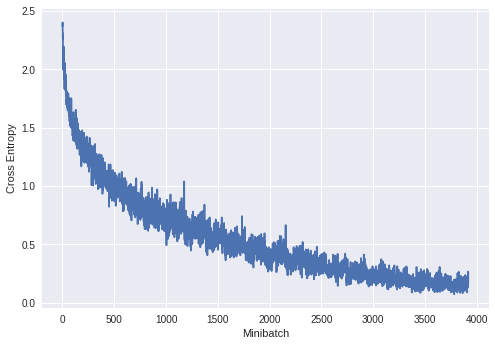

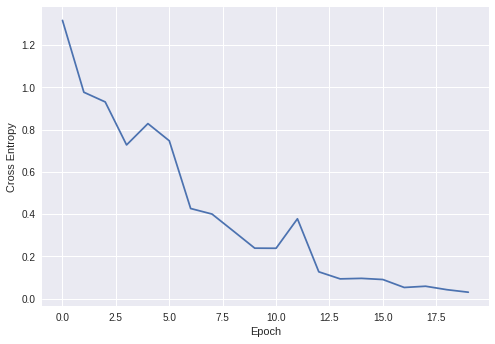

In [10]:
##########################
### MODEL
##########################

class ConvNet3(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()
        
        #### YOUR CODE
        self.conv1 = nn.Conv2d(3, 64,    kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.batch2 = nn.BatchNorm2d(192)
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size = 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.2)
        self.batch3 = nn.BatchNorm2d(384)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout2d(0.2)
        self.batch4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size = 5, stride = 1, padding = 2)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout5 = nn.Dropout2d(0.2)
        self.batch5 = nn.BatchNorm2d(256)
        
        
        self.linear1 = nn.Linear(256, 4096)
        self.lin_drop_1 = nn.Dropout(0.5)
        self.lin_batch_1 = nn.BatchNorm1d(4096)
        
        self.linear2 = nn.Linear(4096, 4096)
        self.lin_drop_2 = nn.Dropout(0.5)
        self.lin_batch_2 = nn.BatchNorm1d(4096)
        
        self.linear3 = nn.Linear(4096, num_classes) 

    def forward(self, x):

        #### YOUR CODE
        out_1 = self.conv1(x)
        out_1 = self.batch1(out_1)
        out_1 = self.dropout1(out_1)
        out_1 = torch.relu(out_1)
        out_1 = self.pool1(out_1)
        
        out_2 = self.conv2(out_1)
        out_2 = self.batch2(out_2)
        out_2 = self.dropout2(out_2)
        out_2 = torch.relu(out_2)
        out_2 = self.pool2(out_2)
        
        out_3 = self.conv3(out_2)
        out_3 = self.batch3(out_3)
        out_3 = self.dropout3(out_3)
        out_3 = torch.relu(out_3)
        out_3 = self.pool3(out_3)
        
        out_4 = self.conv4(out_3)
        out_4 = self.batch4(out_4)
        out_4 = self.dropout4(out_4)
        out_4 = torch.relu(out_4)
        out_4 = self.pool4(out_4)
        
        out_5 = self.conv5(out_4)
        out_5 = self.batch5(out_5)
        out_5 = self.dropout5(out_5)
        out_5 = self.pool5(out_5)
        out_5 = torch.relu(out_5)
        #print(out_5.size())
        out_5 = out_5.view(-1,256)
        #print(out_5.size())
        
        out_6 = self.linear1(out_5)
        out_6 = self.lin_batch_1(out_6)
        out_6 = torch.relu(out_6)
        out_6 = self.lin_drop_1(out_6)
        
        out_7 = self.linear2(out_6)
        out_7 = self.lin_batch_2(out_7)
        out_7 = torch.relu(out_7)
        out_7 = self.lin_drop_2(out_7)
        
        out_8 = self.linear3(out_7)
        
        
        logits = out_8
        probas = F.softmax(logits, dim=1)
        return logits, probas


    
torch.manual_seed(RANDOM_SEED)

model3 = ConvNet3(NUM_CLASSES)
model3.to(DEVICE)

optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model3, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# del model3  # to save memory if you don't use it anymore

<br>
<br>

## 4) Going All-Convolutional

In this 4th part, your task is to remove all maxpooling layers and replace the fully-connected layers by convolutional layers. Note that the number of elements of the activation tensors in the hidden layers should not change. I.e., when you remove the max-pooling layers, you need to increase the stride of the convolutional layers from 1 to 2 to achieve the same scaling. Furthermore, you can replace a fully-connected conmvolutional layer by a convolutional layer using stride=1 and a kernel with height and width equal to 1.

The new architecture is as follows (changes, compared to the previous section, are highlighted in red):

![](architecture-4.png)

Epoch: 001/020 | Batch 0000/0196 | Cost: 2.3680
Epoch: 001/020 | Batch 0150/0196 | Cost: 1.7963
Epoch: 001/020 | Train: 36.294%
Time elapsed: 1.37 min
Epoch: 002/020 | Batch 0000/0196 | Cost: 1.8718
Epoch: 002/020 | Batch 0150/0196 | Cost: 1.7061
Epoch: 002/020 | Train: 40.248%
Time elapsed: 2.79 min
Epoch: 003/020 | Batch 0000/0196 | Cost: 1.6205
Epoch: 003/020 | Batch 0150/0196 | Cost: 1.5788
Epoch: 003/020 | Train: 44.684%
Time elapsed: 4.21 min
Epoch: 004/020 | Batch 0000/0196 | Cost: 1.6401
Epoch: 004/020 | Batch 0150/0196 | Cost: 1.5788
Epoch: 004/020 | Train: 46.566%
Time elapsed: 5.63 min
Epoch: 005/020 | Batch 0000/0196 | Cost: 1.5932
Epoch: 005/020 | Batch 0150/0196 | Cost: 1.6610
Epoch: 005/020 | Train: 48.208%
Time elapsed: 7.04 min
Epoch: 006/020 | Batch 0000/0196 | Cost: 1.5735
Epoch: 006/020 | Batch 0150/0196 | Cost: 1.5319
Epoch: 006/020 | Train: 49.954%
Time elapsed: 8.45 min
Epoch: 007/020 | Batch 0000/0196 | Cost: 1.4848
Epoch: 007/020 | Batch 0150/0196 | Cost: 1.485

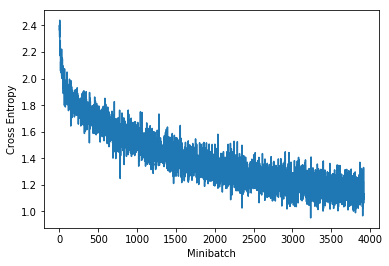

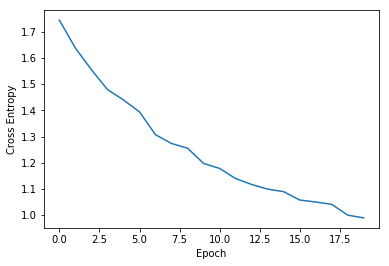

In [12]:
##########################
### MODEL
##########################

class ConvNet4(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet4, self).__init__()
        
        #### YOUR CODE
        self.conv1 = nn.Conv2d(3, 64,  kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride = 2, padding = 2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.batch2 = nn.BatchNorm2d(192)
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size = 3, stride = 2, padding = 1)
        self.dropout3 = nn.Dropout2d(0.2)
        self.batch3 = nn.BatchNorm2d(384)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size = 5, stride = 2, padding = 2)
        self.dropout4 = nn.Dropout2d(0.2)
        self.batch4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size = 5, stride = 2, padding = 2)
        self.dropout5 = nn.Dropout2d(0.2)
        self.batch5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256,4096,kernel_size = 1, stride = 1)
        self.lin_drop_1 = nn.Dropout2d(0.5)
        self.lin_batch_1 = nn.BatchNorm2d(4096)
        
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size = 1, stride = 1)
        self.lin_drop_2 = nn.Dropout2d(0.5)
        self.lin_batch_2 = nn.BatchNorm2d(4096)
        
        self.conv8 = nn.Conv2d(4096, num_classes, kernel_size = 1, stride = 1) 
        

    def forward(self, x):
        #### YOUR CODE
        out_1 = self.conv1(x)
        out_1 = self.batch1(out_1)
        out_1 = self.dropout1(out_1)
        out_1 = torch.relu(out_1)
        
        out_2 = self.conv2(out_1)
        out_2 = self.batch2(out_2)
        out_2 = self.dropout2(out_2)
        out_2 = torch.relu(out_2)
        
        out_3 = self.conv3(out_2)
        out_3 = self.batch3(out_3)
        out_3 = self.dropout3(out_3)
        out_3 = torch.relu(out_3)
        
        out_4 = self.conv4(out_3)
        out_4 = self.batch4(out_4)
        out_4 = self.dropout4(out_4)
        out_4 = torch.relu(out_4)
        
        out_5 = self.conv5(out_4)
        out_5 = self.batch5(out_5)
        out_5 = self.dropout5(out_5)
        out_5 = torch.relu(out_5)
        #print(out_5.size())
        #out_5 = out_5.view(-1,256)
        #print(out_5.size())
        
        out_6 = self.conv6(out_5)
        out_6 = self.lin_batch_1(out_6)
        out_6 = torch.relu(out_6)
        out_6 = self.lin_drop_1(out_6)
        
        out_7 = self.conv7(out_6)
        out_7 = self.lin_batch_2(out_7)
        out_7 = torch.relu(out_7)
        out_7 = self.lin_drop_2(out_7)
        
        out_8 = self.conv8(out_7)
        
        
        x = out_8

        #x = self.conv8(x)
        
        logits = x.view(x.size(0), NUM_CLASSES)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
torch.manual_seed(RANDOM_SEED)

model4 = ConvNet4(NUM_CLASSES)
model4.to(DEVICE)

optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model4, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# del model4

<br>
<br>

## 5) Add Image Augmentation

In this last section, you should use the architecture from the previous section (section 4) but use additional image augmentation during training to improve the generalization performance. 


In particular, you should modify the `train_transform = transforms.Compose([...`) function so that it

- performs a random horizontal flip with propbability 50%
- resizes the image from 32x32 to 40x40
- performs a 32x32 random crop from the 40x40 images
- normalizes the pixel intensities such that they are within the range [-1, 1]

The `test_transform = transforms.Compose([...` function should be modified accordingly, such that it 

- resizes the image from 32x32 to 40x40
- performs a 32x32 **center** crop from the 40x40 images
- normalizes the pixel intensities such that they are within the range [-1, 1]

In [13]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(40),
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:2*x  - 1)
        #### YOUR CODE
])

test_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:2*x - 1)
        #### YOUR CODE
])


train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=train_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=test_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)


torch.manual_seed(RANDOM_SEED)

model4 = ConvNet4(NUM_CLASSES)
model4.to(DEVICE)

optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model4, train_loader, test_loader)

Files already downloaded and verified
Epoch: 001/020 | Batch 0000/0196 | Cost: 2.3680
Epoch: 001/020 | Batch 0150/0196 | Cost: 1.7963
Epoch: 001/020 | Train: 36.294%
Time elapsed: 1.42 min
Epoch: 002/020 | Batch 0000/0196 | Cost: 1.8718
Epoch: 002/020 | Batch 0150/0196 | Cost: 1.7061
Epoch: 002/020 | Train: 40.248%
Time elapsed: 2.84 min
Epoch: 003/020 | Batch 0000/0196 | Cost: 1.6205
Epoch: 003/020 | Batch 0150/0196 | Cost: 1.5788
Epoch: 003/020 | Train: 44.684%
Time elapsed: 4.26 min
Epoch: 004/020 | Batch 0000/0196 | Cost: 1.6401
Epoch: 004/020 | Batch 0150/0196 | Cost: 1.5788
Epoch: 004/020 | Train: 46.566%
Time elapsed: 5.68 min
Epoch: 005/020 | Batch 0000/0196 | Cost: 1.5932
Epoch: 005/020 | Batch 0150/0196 | Cost: 1.6610
Epoch: 005/020 | Train: 48.208%
Time elapsed: 7.09 min
Epoch: 006/020 | Batch 0000/0196 | Cost: 1.5735
Epoch: 006/020 | Batch 0150/0196 | Cost: 1.5319
Epoch: 006/020 | Train: 49.954%
Time elapsed: 8.53 min
Epoch: 007/020 | Batch 0000/0196 | Cost: 1.4848
Epoch: 0

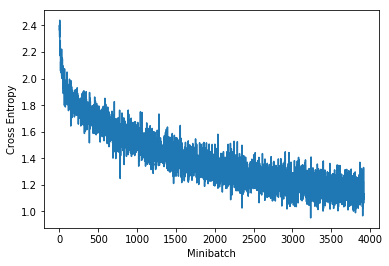

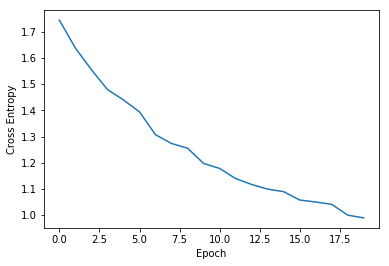

In [14]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# summary(model1, input_size=(3, 32, 32))

<br>
<br>

## 6) Optional: Training the network for 200 epochs

In this optional section, train the network from the previous part for 200 epochs to see how it performs as the training loss converges. This will take about 50 minutes and is optional (you will not receive a penalty if you don't run this section).

In [17]:
NUM_EPOCHS = 200

torch.manual_seed(RANDOM_SEED)

model4 = ConvNet4(NUM_CLASSES)
model4.to(DEVICE)

optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model4, train_loader, test_loader)

Epoch: 001/200 | Batch 0000/0196 | Cost: 2.3680
Epoch: 001/200 | Batch 0150/0196 | Cost: 1.7963
Epoch: 001/200 | Train: 36.294%
Time elapsed: 1.41 min
Epoch: 002/200 | Batch 0000/0196 | Cost: 1.8718
Epoch: 002/200 | Batch 0150/0196 | Cost: 1.7061
Epoch: 002/200 | Train: 40.248%
Time elapsed: 2.83 min
Epoch: 003/200 | Batch 0000/0196 | Cost: 1.6205
Epoch: 003/200 | Batch 0150/0196 | Cost: 1.5788
Epoch: 003/200 | Train: 44.684%
Time elapsed: 4.25 min
Epoch: 004/200 | Batch 0000/0196 | Cost: 1.6401
Epoch: 004/200 | Batch 0150/0196 | Cost: 1.5788
Epoch: 004/200 | Train: 46.566%
Time elapsed: 5.67 min
Epoch: 005/200 | Batch 0000/0196 | Cost: 1.5932
Epoch: 005/200 | Batch 0150/0196 | Cost: 1.6610
Epoch: 005/200 | Train: 48.208%
Time elapsed: 7.07 min
Epoch: 006/200 | Batch 0000/0196 | Cost: 1.5735
Epoch: 006/200 | Batch 0150/0196 | Cost: 1.5319
Epoch: 006/200 | Train: 49.954%
Time elapsed: 8.46 min
Epoch: 007/200 | Batch 0000/0196 | Cost: 1.4848
Epoch: 007/200 | Batch 0150/0196 | Cost: 1.485

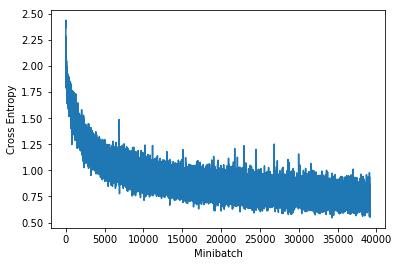

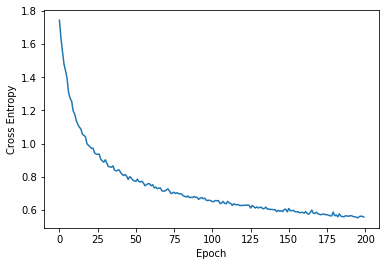

In [18]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

<br>
<br>

## Conclusions (Your Answers Required)

Now that you implemented the AlexNet-like architecture and made several modifications to it, please report the number of learnable parameters for each model, i.e., the weights and biases and batchnorm parameters, etc. (excluding the parameters of the ADAM optimizer). Also, please paste the training and test set accuracies below.


---

- **Model from section 1)**
    - Train accuracy: 98.440%
    - Test accuracy: 71.98%

Number of learnable parameters: (include your computation to receive partial points if the final answer is wrong)

[insert computation and answer]


- Conv2d (1) 5 * 5 * 3 * 64 + 64 = 4864
- Conv2d (2) 5 * 5 * 64 * 192 + 192 = 307392
- Conv2d (3) 3 * 3 * 192 * 384 + 384 = 663936
- Conv2d (4) 5 * 5 * 384 * 256 + 256 = 2457856
- Conv2d (5) 5 * 5 * 256 * 256 + 256 = 1638656
- FC (1)     4096 * 256 + 4096 = 1052672
- FC (2)     4096 * 4096 + 4096 = 16781312
- FC (3)     4096 * 10 + 10 = 40970
- Total number of parameters: 4864 + 307392 + 663936 + 2457856 + 1638656 + 1052672 + 16781312 + 40970 = 22947658

---

- **Model from section 2)**
    - Train accuracy: 90.732%
    - Test accuracy: 75.46%

Number of learnable parameters: (include your computation to receive partial points if the final answer is wrong)

[insert computation and answer]


- Conv2d (1) 5 * 5 * 3 * 64 + 64 = 4864
- Conv2d (2) 5 * 5 * 64 * 192 + 192 = 307392
- Conv2d (3) 3 * 3 * 192 * 384 + 384 = 663936
- Conv2d (4) 5 * 5 * 384 * 256 + 256 = 2457856
- Conv2d (5) 5 * 5 * 256 * 256 + 256 = 1638656
- FC (1)     4096 * 256 + 4096 = 1052672
- FC (2)     4096 * 4096 + 4096 = 16781312
- FC (3)     4096 * 10 + 10 = 40970
- Total number of parameters: 4864 + 307392 + 663936 + 2457856 + 1638656 + 1052672 + 16781312 + 40970 = 22947658



---

- **Model from section 3)**
    - Train accuracy: 99.138%
    - Test accuracy: 80.99%

Number of learnable parameters: (include your computation to receive partial points if the final answer is wrong)

[insert computation and answer]


- Conv2d (1) 5 * 5 * 3 * 64 + 64 + 64*2 = 4992
- Conv2d (2) 5 * 5 * 64 * 192 + 192 + 192*2 = 307776
- Conv2d (3) 3 * 3 * 192 * 384 + 384 + 384*2 = 664704
- Conv2d (4) 5 * 5 * 384 * 256 + 256 + 256*2 = 2458368
- Conv2d (5) 5 * 5 * 256 * 256 + 256 + 256*2 = 1639168
- FC (1)     4096 * 256 + 4096 + 4096*2 = 1060864
- FC (2)     4096 * 4096 + 4096 + 4096*2 = 116789504
- FC (3)     4096 * 10 + 10 = 40970
- Total number of parameters: 4992 + 307776 + 664704 + 2458368 + 1639168 + 1060864 + 16789504 + 40970 = 22966346



---

- **Model from section 4)**
    - Train accuracy: 65.362%
    - Test accuracy: 74.98%

Number of learnable parameters: (include your computation to receive partial points if the final answer is wrong)

[insert computation and answer]


- Conv2d (1) 5 * 5 * 3 * 64 + 64 + 64*2 = 4992
- Conv2d (2) 5 * 5 * 64 * 192 + 192 + 192*2 = 307776
- Conv2d (3) 3 * 3 * 192 * 384 + 384 + 384*2 = 664704
- Conv2d (4) 5 * 5 * 384 * 256 + 256 + 256*2 = 2458368
- Conv2d (5) 5 * 5 * 256 * 256 + 256 + 256*2 = 1639168
- FC (1)     4096 * 256 + 4096 + 4096*2 = 1060864
- FC (2)     4096 * 4096 + 4096 + 4096*2 = 116789504
- FC (3)     4096 * 10 + 10 = 40970
- Total number of parameters: 4992 + 307776 + 664704 + 2458368 + 1639168 + 1060864 + 16789504 + 40970 = 22966346




---

- **Model from section 5)**
    - Train accuracy: 65.362%
    - Test accuracy: 74.98%

Number of learnable parameters: (include your computation to receive partial points if the final answer is wrong)

[insert computation and answer]


- Conv2d (1) 5 * 5 * 3 * 64 + 64  + 64*2 = 4992
- Conv2d (2) 5 * 5 * 64 * 192 + 192 + 192*2 = 307776
- Conv2d (3) 3 * 3 * 192 * 384 + 384 + 384*2 = 664704
- Conv2d (4) 5 * 5 * 384 * 256 + 256 + 256*2 = 2458368
- Conv2d (5) 5 * 5 * 256 * 256 + 256 + 256*2 = 1639168
- FC (1)     4096 * 256 + 4096 + 4096*2 = 1060864
- FC (2)     4096 * 4096 + 4096 + 4096*2 = 116789504
- FC (3)     4096 * 10 + 10 = 40970
- Total number of parameters: 4992 + 307776 + 664704 + 2458368 + 1639168 + 1060864 + 16789504 + 40970 = 22966346



---


---

- **Model from section 6) [optional]**
    - Train accuracy: 80.944%
    - Test accuracy: 85.89%


---